In [7]:
import gpxpy
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Filtro de Kalman para dados de GPS (extensão .gpx)

Os dados usados aqui são obtidos através de exportação no site da Garmin. Acredito que via Strava também é possível.

In [88]:
def readData(url):
    with open(url) as fh:
        gpx_file = gpxpy.parse(fh)

    segment = gpx_file.tracks[0].segments[0]
    coords = pd.DataFrame([{'lat': p.latitude, 
                            'lon': p.longitude, 
                            'ele': p.elevation,
                            'time': p.time} for p in segment.points])
    coords.set_index('time', drop=True, inplace=True)

    start_time, end_time = segment.get_time_bounds()
    duration = end_time - start_time

    segment.points[0].speed = 0.0
    segment.points[-1].speed = 0.0
    gpx_file.add_missing_speeds()

    coords['speed'] = [p.speed for p in segment.points]
    coords['speed'] *= 3.6

    coords.index = (coords.index - coords.index[0]).total_seconds()
    
    return coords

In [158]:
coords = readData('./../activity_12412886281.gpx')

all_indexes = np.arange(0,len(coords.index),1)
idx_stopped = np.setdiff1d(all_indexes,coords.index)

idx_stopped_new = []
for i in range(len(idx_stopped)-1):

    if ((idx_stopped[i] + 1) == idx_stopped[i+1]):
        idx_stopped_new.append(idx_stopped[i])

        if (i == len(idx_stopped) - 1):
            idx_stopped_new.append(idx_stopped_new[i+1])

new_coords = coords.reindex(np.asarray(idx_stopped_new), fill_value = -1)

coords = pd.concat([coords, new_coords])
coords = coords.sort_index()
coords.head()

,lat,lon,ele,speed
time,,,,
0.0,-27.060759,-51.193396,770.599976,0.000000
1.0,-27.060759,-51.193393,770.599976,1.166613
2.0,-27.060759,-51.193390,770.599976,1.897273
3.0,-27.060757,-51.193383,770.599976,4.703419
4.0,-27.060753,-51.193364,770.799988,6.394993


In [159]:
coords.loc[coords['speed'] == -1]

,lat,lon,ele,speed
time,,,,
2231.0,-1.0,-1.0,-1.0,-1.0
2232.0,-1.0,-1.0,-1.0,-1.0
2233.0,-1.0,-1.0,-1.0,-1.0
2234.0,-1.0,-1.0,-1.0,-1.0
2235.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...
3536.0,-1.0,-1.0,-1.0,-1.0
3537.0,-1.0,-1.0,-1.0,-1.0
3538.0,-1.0,-1.0,-1.0,-1.0


In [152]:
all_indexes = np.arange(0,len(coords.index),1)
missing_values = np.setdiff1d(all_indexes,coords.index)

In [153]:
missing_values

array([1321, 2231, 2232, ..., 3539, 3540, 3541])

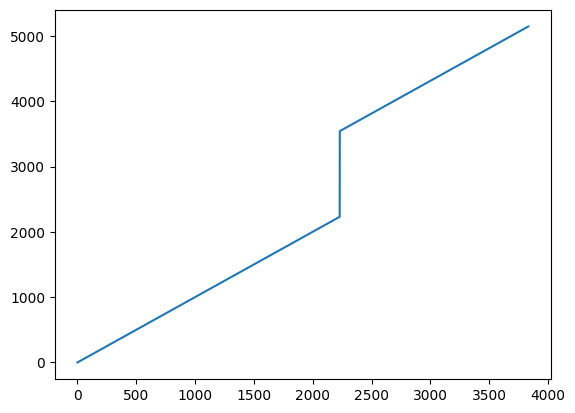

In [151]:
plt.plot(coords.index)

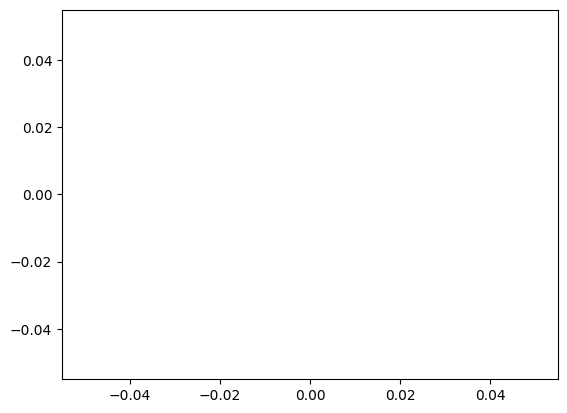

In [149]:
plt.plot(idx_stopped)

In [142]:
coords.loc[coords['speed'] == -1]

,lat,lon,ele,speed
time,,,,
2231.0,-1.0,-1.0,-1.0,-1.0
2232.0,-1.0,-1.0,-1.0,-1.0
2233.0,-1.0,-1.0,-1.0,-1.0
2234.0,-1.0,-1.0,-1.0,-1.0
2235.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...
3536.0,-1.0,-1.0,-1.0,-1.0
3537.0,-1.0,-1.0,-1.0,-1.0
3538.0,-1.0,-1.0,-1.0,-1.0


In [143]:
gps_data = np.asarray([coords['lat'], coords['lon']])
gps_data = gps_data.T

Os dados estão no formato (latitude, longitude). Com base nestes dois valores medidos para cada instante de tempo com periodicidade de 1 Hz (1 segundo), serão estimados as posições e as velocidades através do Filtro de Kalman linear.

In [144]:
# Função para inicializar o filtro de Kalman
def initialize_kalman_filter(initial_state, initial_covariance):
    state = initial_state
    covariance = initial_covariance
    return state, covariance

# Função para atualizar o filtro de Kalman com base nas novas observações de GPS
def update_kalman_filter(state, covariance, observation, process_noise, measurement_noise):
    
    state_predict = np.dot(A, state)
    covariance_predict = np.dot(np.dot(A, covariance), A.T) + process_noise
    
    # Ganho de Kalman:
    # 
    # K = PH'(HPH'+R)^(-1)
    kalman_gain = np.dot(np.dot(covariance_predict, H.T), np.linalg.inv(np.dot(np.dot(H, covariance_predict), H.T) + measurement_noise))
    
    # Atualização do estado e da covariância
    state_update = state_predict + np.dot(kalman_gain, (observation - np.dot(H, state_predict)))
    covariance_update = np.dot((np.eye(len(state)) - np.dot(kalman_gain, H)), covariance_predict)
    
    return state_update, covariance_update

# Parâmetros do sistema
dt = 1.0  # Intervalo de tempo entre as observações (em segundos)

# Matrizes do modelo do sistema
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Variâncias do ruído do processo e de medição
process_noise_variance = 0.01  # Variância do ruído do processo (ajuste conforme necessário)
measurement_noise_variance = 0.1  # Variância do ruído de medição (ajuste conforme necessário)

# Matrizes de covariância do ruído do processo e de medição
process_noise = np.eye(4) * process_noise_variance
measurement_noise = np.eye(2) * measurement_noise_variance

# Condição inicial: [x, y, vx, vy]
# initial_state = np.array([0, 0, 0, 0])
initial_state = np.array([coords['lat'][0], coords['lon'][0], 0, 0])

# Covariância inicial (ajuste conforme necessário)
initial_covariance = np.eye(4)

# Inicialização do filtro de Kalman
estimated_state, estimated_covariance = initialize_kalman_filter(initial_state, initial_covariance)

# Atualização do filtro de Kalman com dados de GPS
filtered_data = []
for observation in gps_data:
    estimated_state, estimated_covariance = update_kalman_filter(estimated_state, estimated_covariance, observation, process_noise, measurement_noise)

    filtered_data.append(estimated_state)

filtered_data = np.asarray(filtered_data)
filtered_speeds_components = filtered_data[:,2:]*111.11e3*3.6
filtered_speeds_scalar = np.sqrt(np.square(filtered_speeds_components[:,0]) + np.square(filtered_speeds_components[:,1]))

original_speeds_scalar = np.asarray(coords['speed'])

KeyError: 0

In [116]:
idx_stopped = np.where(original_speeds_scalar == -1)[0]

filtered_speeds_scalar[idx_stopped] = 0
original_speeds_scalar[idx_stopped] = 0

In [95]:
filtered_speeds_scalar.shape

(5144,)

In [96]:
np.asarray(coords['speed']).shape

(5144,)

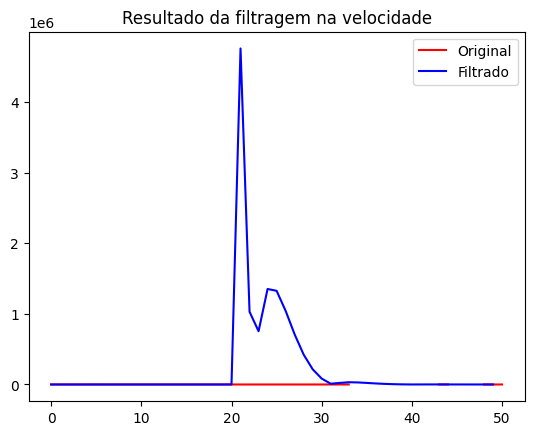

In [117]:
plt.title('Resultado da filtragem na velocidade')
plt.plot(np.asarray(coords['speed'][1300:1350]),color='red',label='Original')
plt.plot(filtered_speeds_scalar[1300:1350],color='blue',label='Filtrado')
plt.legend()

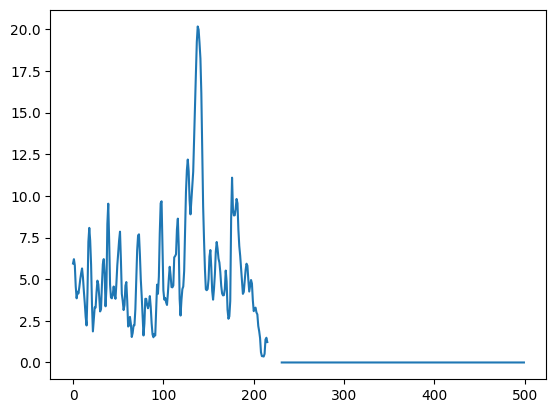

In [122]:
plt.plot(original_speeds_scalar[2000:2500])

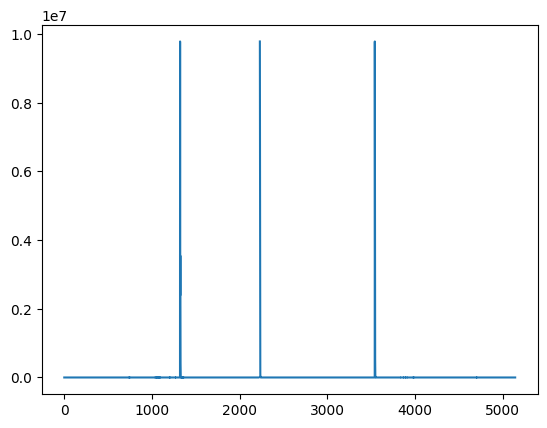

In [98]:
plt.plot(filtered_speeds_scalar - np.asarray(coords['speed']))